### Data Ingestion

In [1]:
import pandas as pd
from pandas import DataFrame, Series

In [2]:
users = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_users-intern.csv")
user_engagement = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_user_engagement-intern.csv")

### 1) Calculating Adoption Rate

In [3]:
# sort user_engagemenet and drop rows with similar user_id and date
user_engagement = user_engagement.sort_values(by=['user_id', 'time_stamp'])
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])
user_engagement['date'] = user_engagement['time_stamp'].dt.date
user_engagement = user_engagement[["date","user_id"]].drop_duplicates()

In [4]:
def is_adopted_user(df, period=7, freq=3):
	"""
	INPUT
	df: dataframe of user activity
	period: time period we want to look at, default 7
	freq: is the number of days of the period we want the user to have logged in, default 3

	OUTPUT
	adopted_user: returns whether or not the user had 3 consecutive logins within a 7 day period
	"""
	adopted_user = False
	if len(df) < freq:
		return adopted_user
	else:
		for i in range(len(df)-freq+1):
			if (df['date'].iloc[i+freq-1] - df['date'].iloc[i]) < pd.Timedelta(days=period):
				adopted_user = True
				return adopted_user
	return adopted_user

In [5]:
# find adopted users
grouped_users = user_engagement.groupby('user_id')
adoted_users = pd.DataFrame(grouped_users.filter(lambda x : is_adopted_user(df=x, period=7, freq=3) ==True)["user_id"].drop_duplicates())
adoted_users['adopted_user'] = 1

# add column adopted_user to users
users = pd.merge(adoted_users, users, how='outer', left_on='user_id', right_on='object_id')
users['adopted_user'] = users['adopted_user'].fillna(0)

In [6]:
users['adopted_user'].agg('mean')

0.1335

To find the adopted users I did exactly as you asked and considered only the users who have ever connected 3 different days in a 7 days period.
To compute the adoption rate I computed the number of adopted users and devided it by the number of total users.

The adoption rate is 13.35%

### 2) Methodology

My strategy for this problem was using a modeling approach. I first started with feature engineering, then built a tree based model and finally extracted the features that the model relied on most to do the prediction. 

For feature extraction:
I first extracted day, month and year from the creation_time
From the column invited_by_user_id I extracted the feature invited_by_user which value is 1 if there was the user was invited, 0 otherwise.
From the column invited_by_user_id I also extracted invited_by_adopted_user which value is 1 if the user was invited by an adopted user or not.

I used all the features besides
The features that I used are the creation_source, opted_in_to_mailing_list, enabled_for_marketing_drip, org_id, invited_by_user, invited_by_adopted_user, and creation_time. I haven't used last_session_creation_time, because it has 50% null and I didn't want to focus a lot on it for now. I also didn't use email_domain because I don't see any relationship between them.

I trained a Random forest classifier, and since the data is unbalanced (only 13% adopted) I uesd the f-1 score takes that aspect into consideration. I wanted to see how well the model would perform on that data.

Feature engineering

In [7]:
# Extract year, month and day from creation_time
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['creation_date'] = users['creation_time'].dt.date

users['creation_time_year'] = users['creation_time'].dt.year
users['creation_time_month'] = users['creation_time'].dt.month
users['creation_time_day'] = users['creation_time'].dt.day

C:\Users\salah\AppData\Local\Temp\ipykernel_37188\3836794742.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  users['creation_time'] = pd.to_datetime(users['creation_time'])


In [10]:
# Extract feature invited_by_user
users['invited_by_user'] = users['invited_by_user_id'].notna()

In [11]:
# Extract feature invited_by_adopted_user VALUES: 0,1
adopted_users = list(users['user_id'].dropna().drop_duplicates())
users['invited_by_adopted_user'] = users.apply(lambda x: 1 if x['invited_by_user_id'] in adopted_users else 0, axis=1)

In [16]:
users = pd.get_dummies(users, columns=['creation_source'])

In [ ]:
#shuffle the data
shuffled_df = users.sample(frac=1, random_state=42)  

# define features and target variable
X = shuffled_df[['creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user', 
       "invited_by_adopted_user", 'creation_time_year', 'creation_time_month', 'creation_time_day']]
y = shuffled_df['adopted_user']

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train random forest classifier
class_weights = {0: 1, 1: 9} 
rf = RandomForestClassifier(
    n_estimators=200,  # Increase n_estimators for more regularization
    max_depth=10,  # Set a max depth to control tree depth
    min_samples_split=2,  # Adjust minimum samples for splitting
    min_samples_leaf=1,  # Adjust minimum samples for leaves
    max_features=6,  # Limit the number of features considered for splitting
    random_state=42  # Set a random state for reproducibility
    ,class_weight=class_weights)

rf.fit(X_train, y_train)

f1_scorer = make_scorer(f1_score)
f1_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring=f1_scorer)

# get feature importances
importances = rf.feature_importances_

In [23]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
# Make predictions on the test set
y_pred = rf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print("test f1 : ",f1)
recall = recall_score (y_test, y_pred)
print("test recall : ",recall)


train f1 :  0.43012284137439916
train recall :  0.9415432579890881
test f1 :  0.2844175491679274
test recall :  0.5893416927899686


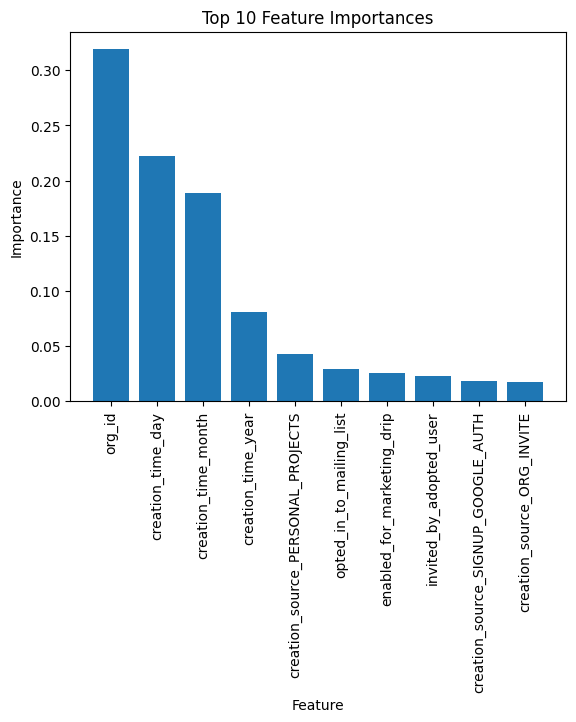

In [22]:
import matplotlib.pyplot as plt

# Sort features by importance
feature_names = X.columns
sorted_idx = importances.argsort()[::-1]

# Plot the top N features
top_n = 10  # Change this to the desired number of top features to plot
plt.bar(range(top_n), importances[sorted_idx][:top_n], align="center")
plt.xticks(range(top_n), feature_names[sorted_idx][:top_n], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top {} Feature Importances".format(top_n))
plt.show()

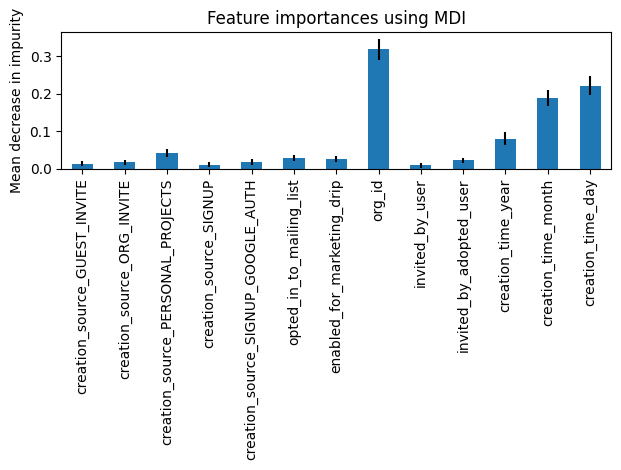

In [24]:
import numpy as np
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)


feature_names = list(X.columns)
# feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [25]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

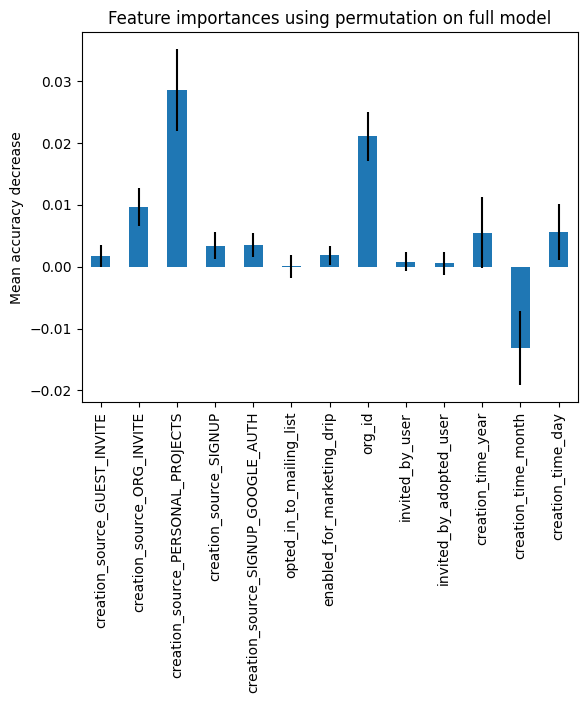

In [26]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
plt.show()

### 3) What Factors Predict User Adoption?

I didn't take lots of time to build the best model but the one that I built has f1_score of 28% and a recall of 59% on test data. The factors that the model used most to predict user adoption are: creation_source, org_id, creation_time. 

One of the reasons why I didn't use last_session_creation_time is that it is related to time. If we could use the logging info of the users then we might use a time series forecasting model which might be more useful. 